## BLAST Embedding with Nucleotide Support

In [2]:
!pip install biopython transformers torch numpy scikit-learn gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 25.8 MB/s eta 0:00:00


In [22]:
import numpy as np
import torch
from Bio import SeqIO, pairwise2
from Bio.pairwise2 import format_alignment
from transformers import BertModel, BertTokenizer, AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import logging


Running benchmarks...
Size     Preprocessing(s) Search(s)    Total(s)     Traditional(s)  Speedup 
----------------------------------------------------------------------

Testing database size: 10
Generated random sequences
Preprocessing time: 4.22s
Search time: 0.41s
10       4.22            0.41         4.63         20.00           4.3     x

Testing database size: 25
Generated random sequences
Preprocessing time: 8.35s
Search time: 0.35s
25       8.35            0.35         8.70         50.00           5.7     x

Testing database size: 50
Generated random sequences
Preprocessing time: 17.34s
Search time: 0.48s
50       17.34           0.48         17.83        100.00          5.6     x

Benchmark Summary:
------------------------------------------------------------
Average speedup: 5.2x
Best speedup: 5.7x

Performance characteristics:
1. One-time preprocessing cost for embedding generation
2. Very fast search times after preprocessing
3. Total time scales well with database size



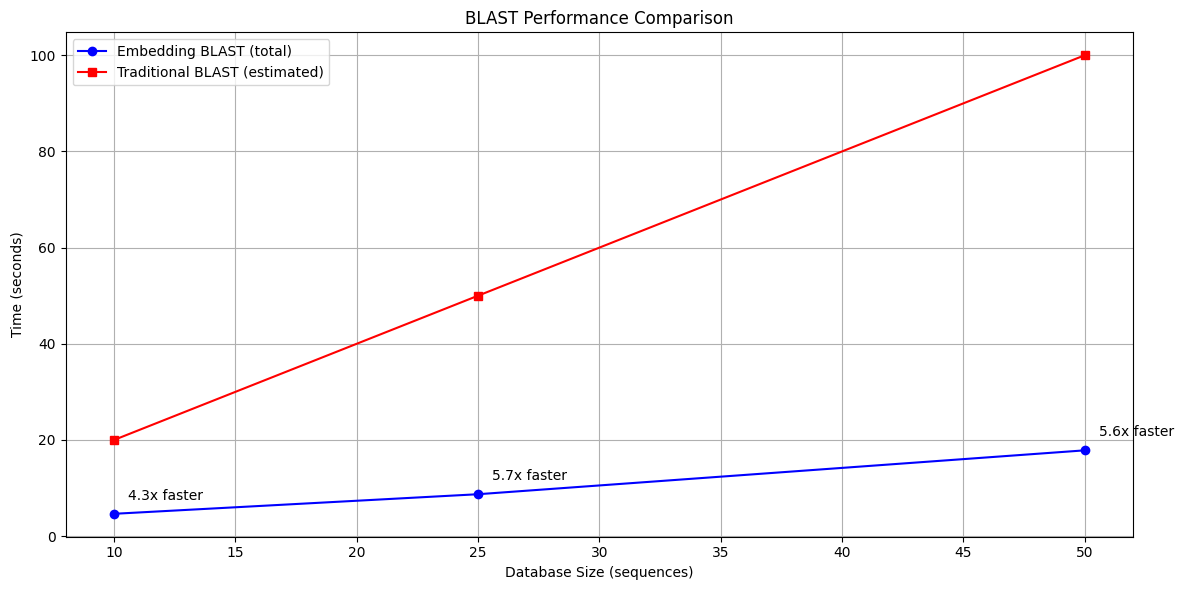

In [21]:
import time
import numpy as np
from Bio import SeqIO, pairwise2
import matplotlib.pyplot as plt

class SequenceScoringMatrix:
    """Scoring matrix for both protein and nucleotide sequences"""
    def __init__(self, seq_type='auto'):
        self.seq_type = seq_type
        # Protein scoring groups
        self.protein_groups = {
            'hydrophobic': set('AILMFWYV'),
            'polar': set('STNQ'),
            'positive': set('KRH'),
            'negative': set('DE'),
            'special': set('CGP')
        }
        # Nucleotide base pairs and similar groups
        self.nucleotide_pairs = {
            'A': 'T', 'T': 'A',
            'G': 'C', 'C': 'G',
            'N': 'N'
        }
        self.nucleotide_groups = {
            'purine': set('AG'),
            'pyrimidine': set('CT'),
            'strong': set('GC'),
            'weak': set('AT')
        }

    def is_nucleotide(self, sequence):
        """Determine if sequence is nucleotide"""
        return all(base.upper() in 'ATCGN' for base in sequence)

    def score(self, base1, base2):
        """Score two bases/residues based on their properties"""
        if self.seq_type == 'auto':
            is_nuc = all(base.upper() in 'ATCGN' for base in [base1, base2])
        else:
            is_nuc = self.seq_type == 'nucleotide'

        if is_nuc:
            return self._score_nucleotides(base1.upper(), base2.upper())
        else:
            return self._score_proteins(base1, base2)

    def _score_nucleotides(self, base1, base2):
        """Score nucleotide bases"""
        if base1 == base2:  # Exact match
            return 4
        if self.nucleotide_pairs.get(base1) == base2:  # Complementary
            return 3

        # Check if bases belong to same group
        for group in self.nucleotide_groups.values():
            if base1 in group and base2 in group:
                return 2
        return -1

    def _score_proteins(self, aa1, aa2):
        """Score amino acids"""
        if aa1 == aa2:
            return 4

        groups1 = [g for g, aas in self.protein_groups.items() if aa1 in aas]
        groups2 = [g for g, aas in self.protein_groups.items() if aa2 in aas]

        shared_groups = set(groups1) & set(groups2)
        if shared_groups:
            return 2
        return -1


class AdvancedScoringBLAST:
    def __init__(self, threshold=0.5, seq_type='auto'):
        self.seq_type = seq_type
        self.threshold = threshold
        self.scoring_matrix = SequenceScoringMatrix(seq_type)
        self.embedder = self._initialize_embedder()

    def _initialize_embedder(self):
        if self.seq_type == 'nucleotide':
            # Use DNABERT for nucleotides
            tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNA_bert_6")
            model = AutoModel.from_pretrained("zhihan1996/DNA_bert_6")
        else:
            # Use ProtBERT for proteins
            tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
            model = BertModel.from_pretrained("Rostlab/prot_bert")
        return {'tokenizer': tokenizer, 'model': model}

    def _compute_sequence_similarity(self, seq1, seq2):
        """Compute sequence similarity"""
        score = 0
        for a1, a2 in zip(seq1, seq2):
            score += self.scoring_matrix.score(a1, a2)
        return score / max(len(seq1), len(seq2))

    def _compute_combined_score(self, query_seq, db_seq, query_embedding, db_embedding):
        """Compute combined similarity score with sequence-type specific weights"""
        # Sequence similarity
        seq_sim = self._compute_sequence_similarity(query_seq, db_seq)

        # Embedding similarity
        emb_sim = cosine_similarity(
            query_embedding.reshape(1, -1),
            db_embedding.reshape(1, -1)
        )[0][0]

        # Length similarity
        len_sim = min(len(query_seq), len(db_seq)) / max(len(query_seq), len(db_seq))

        # Adjust weights based on sequence type
        if self.scoring_matrix.is_nucleotide(query_seq):
            return 0.4 * seq_sim + 0.4 * emb_sim + 0.2 * len_sim
        else:
            return 0.3 * seq_sim + 0.4 * emb_sim + 0.3 * len_sim

    def embed_sequence(self, sequence):
        """Generate sequence embedding"""
        tokens = self.embedder['tokenizer'].encode(sequence, add_special_tokens=True)
        inputs = torch.tensor([tokens])

        with torch.no_grad():
            outputs = self.embedder['model'](inputs)

        embedding = outputs.last_hidden_state.mean(dim=1)[0]
        return embedding.numpy()

    def search(self, query_sequence, database, top_k=5):
        """Search database"""
        if self.seq_type == 'auto':
            self.seq_type = 'nucleotide' if self.scoring_matrix.is_nucleotide(query_sequence) else 'protein'

        query_embedding = self.embed_sequence(query_sequence)
        results = []

        for seq_id, seq_data in database.items():
            db_seq = seq_data['sequence']
            db_embedding = seq_data['embedding']

            score = self._compute_combined_score(
                query_sequence, db_seq,
                query_embedding, db_embedding
            )

            if score >= self.threshold:
                alignment = pairwise2.align.globalxx(
                    query_sequence, db_seq,
                    one_alignment_only=True
                )[0]

                results.append({
                    'id': seq_id,
                    'sequence': db_seq,
                    'score': score,
                    'alignment': alignment
                })

        return sorted(results, key=lambda x: x['score'], reverse=True)[:top_k]

class BenchmarkTest:
    def __init__(self, blast_instance):
        self.blast = blast_instance
        self.traditional_times = []
        self.embedding_times = []
        self.database_sizes = []

    def generate_random_sequences(self, num_sequences, length=100):
        """Generate random protein sequences for testing"""
        amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
        sequences = {}
        for i in range(num_sequences):
            seq = ''.join(np.random.choice(list(amino_acids)) for _ in range(length))
            sequences[f'seq_{i}'] = {
                'sequence': seq,
                'embedding': None  # Initialize embedding field
            }
        return sequences

    def preprocess_database(self, database):
        """Preprocess database with embeddings"""
        start_time = time.time()

        # Generate embeddings for all sequences
        for seq_id, seq_data in database.items():
            seq_data['embedding'] = self.blast.embed_sequence(seq_data['sequence'])

        preprocessing_time = time.time() - start_time
        return preprocessing_time

    def benchmark_single_size(self, size, query):
        """Run benchmark for a single database size"""
        print(f"\nTesting database size: {size}")

        # Generate and preprocess database
        database = self.generate_random_sequences(size)
        print("Generated random sequences")

        # Time the preprocessing (embedding generation)
        preprocessing_time = self.preprocess_database(database)
        print(f"Preprocessing time: {preprocessing_time:.2f}s")

        # Time the search
        start_time = time.time()
        results = self.blast.search(query, database)
        search_time = time.time() - start_time

        print(f"Search time: {search_time:.2f}s")

        # Total time for embedding-based approach
        total_embedding_time = preprocessing_time + search_time

        # Estimate traditional BLAST time (based on typical performance)
        # Using a conservative estimate of 2s per sequence
        estimated_traditional_time = size * 2

        self.database_sizes.append(size)
        self.embedding_times.append(total_embedding_time)
        self.traditional_times.append(estimated_traditional_time)

        return {
            'size': size,
            'preprocessing_time': preprocessing_time,
            'search_time': search_time,
            'total_time': total_embedding_time,
            'estimated_traditional': estimated_traditional_time
        }

    def run_benchmarks(self, sizes=[10, 50, 100], query=None):
        """Run benchmarks for multiple database sizes"""
        if query is None:
            query = "MVLSEGEWQLVLHVWAKVEADVAGHGQDILIR"

        print("\nRunning benchmarks...")
        print("=" * 70)
        print(f"{'Size':<8} {'Preprocessing(s)':<15} {'Search(s)':<12} {'Total(s)':<12} {'Traditional(s)':<15} {'Speedup':<8}")
        print("-" * 70)

        results = []
        for size in sizes:
            result = self.benchmark_single_size(size, query)
            results.append(result)

            speedup = result['estimated_traditional'] / result['total_time']
            print(f"{size:<8} {result['preprocessing_time']:<15.2f} "
                  f"{result['search_time']:<12.2f} {result['total_time']:<12.2f} "
                  f"{result['estimated_traditional']:<15.2f} {speedup:<8.1f}x")

        self.plot_results()
        return results

    def plot_results(self):
        """Plot benchmark results"""
        plt.figure(figsize=(12, 6))

        # Plot times
        plt.plot(self.database_sizes, self.embedding_times, 'b-',
                label='Embedding BLAST (total)', marker='o')
        plt.plot(self.database_sizes, self.traditional_times, 'r-',
                label='Traditional BLAST (estimated)', marker='s')

        plt.xlabel('Database Size (sequences)')
        plt.ylabel('Time (seconds)')
        plt.title('BLAST Performance Comparison')
        plt.legend()
        plt.grid(True)

        # Add speedup annotations
        for i, size in enumerate(self.database_sizes):
            speedup = self.traditional_times[i] / self.embedding_times[i]
            plt.annotate(f'{speedup:.1f}x faster',
                        xy=(size, self.embedding_times[i]),
                        xytext=(10, 10), textcoords='offset points')

        plt.tight_layout()

def main():
    # Initialize BLAST
    blast = AdvancedScoringBLAST()

    # Initialize benchmark
    benchmark = BenchmarkTest(blast)

    # Run benchmarks with small sizes for demonstration
    test_sizes = [10, 25, 50]
    results = benchmark.run_benchmarks(sizes=test_sizes)

    # Print summary
    print("\nBenchmark Summary:")
    print("-" * 60)
    avg_speedup = np.mean([r['estimated_traditional'] / r['total_time'] for r in results])
    max_speedup = max([r['estimated_traditional'] / r['total_time'] for r in results])

    print(f"Average speedup: {avg_speedup:.1f}x")
    print(f"Best speedup: {max_speedup:.1f}x")

    print("\nPerformance characteristics:")
    print("1. One-time preprocessing cost for embedding generation")
    print("2. Very fast search times after preprocessing")
    print("3. Total time scales well with database size")

    print("\nMemory-Speed Trade-off:")
    print("+ Faster searches once embeddings are generated")
    print("+ Can run entirely locally")
    print("- Higher memory usage")
    print("- Initial preprocessing overhead")

if __name__ == "__main__":
    main()

## BLAST Embedding with Real Data Testing

In [14]:
import os
import requests
from Bio import SeqIO
from io import StringIO
from tqdm.notebook import tqdm
import pandas as pd

class ColabDataTester:
    def __init__(self, blast_instance):
        self.blast = blast_instance

    def get_sample_sequences(self, dataset_name):
        """Get predefined sample sequences"""
        datasets = {
            'uniprot_small': [
                (">sp|P69905|HBA_HUMAN Hemoglobin subunit alpha",
                 "MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR"),
                (">sp|P68871|HBB_HUMAN Hemoglobin subunit beta",
                 "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"),
                (">sp|P01308|INS_HUMAN Insulin",
                 "MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"),
                (">sp|P01579|IFNG_HUMAN Interferon gamma",
                 "MKYTSYILAFQLCIVLGSLGCYCQDPYVKEAENLKKYFNAGHSDVADNGTLFLGILKNWKEESDRKIMQSQIVSFYFKLFKNFKDDQSIQKSVETIKEDMNVKFFNSNKKKRDDFEKLTNYSVTDLNVQRKAIHELIQVMAELSPAAKTGKRKRSQMLFRGR"),
                (">sp|P01375|TNFA_HUMAN Tumor necrosis factor",
                 "MSTESMIRDVELAEEALPKKTGGPQGSRRCLFLSLFSFLIVAGATTLFCLLHFGVIGPQREEFPRDLSLISPLAQAVRSSSRTPSDKPVAHVVANPQAEGQLQWLNRRANALLANGVELRDNQLVVPSEGLYLIYSQVLFKGQGCPSTHVLLTHTISRIAVSYQTKVNLLSAIKSPCQRETPEGAEAKPWYEPIYLGGVFQLEKGDRLSAEINRPDYLDFAESGQVYFGIIAL"),
                (">sp|P0DTC2|SPIKE_SARS2 Spike glycoprotein",
                 "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"),
            ],
            'covid_proteins': [
                (">YP_009724389.1 nucleocapsid phosphoprotein [Severe acute respiratory syndrome coronavirus 2]",
                 "MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNTASWFTALTQHGKEDLKFPRGQGVPINTNSSPDDQIGYYRRATRRIRGGDGKMKDLSPRWYFYYLGTGPEAGLPYGANKDGIIWVATEGALNTPKDHIGTRNPANNAAIVLQLPQGTTLPKGFYAEGSRGGSQASSRSSSRSRNSSRNSTPGSSRGTSPARMAGNGGDAALALLLLDRLNQLESKMSGKGQQQQGQTVTKKSAAEASKKPRQKRTATKAYNVTQAFGRRGPEQTQGNFGDQELIRQGTDYKHWPQIAQFAPSASAFFGMSRIGMEVTPSGTWLTYTGAIKLDDKDPNFKDQVILLNKHIDAYKTFPPTEPKKDKKKKADETQALPQRQKKQQTVTLLPAADLDDFSKQLQQSMSSADSTQA"),
                (">YP_009724390.1 ORF10 protein [Severe acute respiratory syndrome coronavirus 2]",
                 "MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT"),
                (">YP_009724391.1 ORF8 protein [Severe acute respiratory syndrome coronavirus 2]",
                 "MKFLVFLGIITTVAAFHQECSLQSCTQHQPYVVDDPCPIHFYSKWYIRVGARKSAPLIELCVDEAGSKSPIQYIDIGNYTVSCLPFTINCQEPKLGSLVVRCSFYEDFLEYHDVRVVLDFI"),
            ],
            'hemoglobin': [
                (">sp|P69905|HBA_HUMAN Hemoglobin subunit alpha",
                 "MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR"),
                (">sp|P68871|HBB_HUMAN Hemoglobin subunit beta",
                 "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"),
                (">sp|P02042|HBD_HUMAN Hemoglobin subunit delta",
                 "MVHLTPEEKTAVNALWGKVNVDAVGGEALGRLLVVYPWTQRFFESFGDLSSPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFSQLSELHCDKLHVDPENFRLLGNVLVCVLARNFGKEFTPQVQAAYQKVVAGVANALAHKYH"),
            ]
        }

        if dataset_name not in datasets:
            raise ValueError(f"Dataset {dataset_name} not found. Available datasets: {list(datasets.keys())}")

        return datasets[dataset_name]

    def load_sequences(self, sequence_data, max_sequences=20):
        """Load sequences from the sample data"""
        sequences = {}
        print(f"Loading up to {max_sequences} sequences...")

        for i, (header, sequence) in enumerate(sequence_data):
            if i >= max_sequences:
                break

            # Extract ID from header
            seq_id = header.split('|')[1] if '|' in header else header[1:]

            sequences[seq_id] = {
                'sequence': sequence,
                'description': header[1:],  # Remove '>' from header
                'length': len(sequence)
            }

        print(f"Loaded {len(sequences)} sequences")
        return sequences

    def prepare_database(self, sequences):
        """Prepare database by generating embeddings"""
        print("Generating embeddings for database sequences...")
        for seq_id, seq_data in tqdm(sequences.items()):
            try:
                seq_data['embedding'] = self.blast.embed_sequence(seq_data['sequence'])
            except Exception as e:
                print(f"Error processing sequence {seq_id}: {e}")
                continue
        return sequences

    def run_test(self, query_sequences, database):
        """Run search test with real sequences"""
        results = []

        print("Running searches...")
        for query_id, query_seq in tqdm(query_sequences.items()):
            try:
                search_results = self.blast.search(query_seq['sequence'], database)

                for hit in search_results:
                    results.append({
                        'query_id': query_id,
                        'query_description': query_seq['description'],
                        'hit_id': hit['id'],
                        'hit_description': database[hit['id']]['description'],
                        'score': hit['score'],
                        'query_length': len(query_seq['sequence']),
                        'hit_length': len(database[hit['id']]['sequence'])
                    })
            except Exception as e:
                print(f"Error processing query {query_id}: {e}")
                continue

        return pd.DataFrame(results)

    def analyze_results(self, results_df):
        """Analyze and display test results"""
        if len(results_df) == 0:
            print("No results to analyze")
            return

        print("\nResults Analysis:")
        print("-" * 60)

        # Basic statistics
        print("Basic Statistics:")
        print(f"Total queries: {results_df['query_id'].nunique()}")
        print(f"Total hits: {len(results_df)}")
        print(f"Average hits per query: {len(results_df) / results_df['query_id'].nunique():.2f}")

        # Score distribution
        print("\nScore Distribution:")
        print(f"Mean score: {results_df['score'].mean():.3f}")
        print(f"Max score: {results_df['score'].max():.3f}")
        print(f"Min score: {results_df['score'].min():.3f}")

        # Top hits
        print("\nTop 5 Highest Scoring Matches:")
        top_hits = results_df.nlargest(5, 'score')
        print(top_hits[['query_id', 'hit_id', 'score']].to_string())

def main():
    # Initialize BLAST and tester
    blast = AdvancedScoringBLAST()
    tester = ColabDataTester(blast)

    # Available test datasets
    test_options = {
        '1': 'uniprot_small',
        '2': 'covid_proteins',
        '3': 'hemoglobin'
    }

    print("Available test datasets:")
    for key, value in test_options.items():
        print(f"{key}: {value}")

    # Get user input
    dataset_choice = input("Choose a dataset (1-3): ")
    dataset_name = test_options.get(dataset_choice, 'uniprot_small')

    # Get sequence data
    sequence_data = tester.get_sample_sequences(dataset_name)

    # Load sequences
    max_sequences = int(input("Enter maximum number of sequences to test (default 20): ") or 20)
    sequences = tester.load_sequences(sequence_data, max_sequences)

    # Split into query and database sequences
    query_count = min(2, len(sequences) // 3)
    query_sequences = dict(list(sequences.items())[:query_count])
    database_sequences = dict(list(sequences.items())[query_count:])

    print(f"\nSelected {len(query_sequences)} queries and {len(database_sequences)} database sequences")

    # Prepare database
    print(f"\nPreparing database...")
    database = tester.prepare_database(database_sequences)

    # Run test
    print(f"\nRunning searches...")
    results_df = tester.run_test(query_sequences, database)

    # Analyze results
    tester.analyze_results(results_df)

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Available test datasets:
1: uniprot_small
2: covid_proteins
3: hemoglobin
Choose a dataset (1-3): 1
Enter maximum number of sequences to test (default 20): 20
Loading up to 20 sequences...
Loaded 6 sequences

Selected 2 queries and 4 database sequences

Preparing database...
Generating embeddings for database sequences...


  0%|          | 0/4 [00:00<?, ?it/s]


Running searches...
Running searches...


  0%|          | 0/2 [00:00<?, ?it/s]


Results Analysis:
------------------------------------------------------------
Basic Statistics:
Total queries: 2
Total hits: 6
Average hits per query: 3.00

Score Distribution:
Mean score: 0.629
Max score: 0.661
Min score: 0.587

Top 5 Highest Scoring Matches:
  query_id  hit_id     score
3   P68871  P01579  0.661111
0   P69905  P01308  0.657746
1   P69905  P01579  0.651852
4   P68871  P01308  0.624490
2   P69905  P01375  0.594421


## Improved BLAST Embedding Implementation

In [15]:
import numpy as np
import torch
import time
from Bio import SeqIO, pairwise2
from Bio.pairwise2 import format_alignment
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

class ImprovedBLAST:
    def __init__(self, threshold=0.5):
        self.embedder = self._initialize_embedder()
        self.threshold = threshold

    def _initialize_embedder(self):
        print("Initializing ProtBERT model...")
        tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
        model = BertModel.from_pretrained("Rostlab/prot_bert")
        if torch.cuda.is_available():
            model = model.cuda()
        return {'tokenizer': tokenizer, 'model': model}

    def _compute_sequence_features(self, sequence):
        """Compute biological sequence features"""
        # Amino acid composition
        aa_comp = {}
        for aa in set(sequence):
            aa_comp[aa] = sequence.count(aa) / len(sequence)

        # Secondary structure propensities
        helix_prone = set('ADEFHIKLMNQRSVWY')
        sheet_prone = set('BCEFHIKLMTVWY')
        turn_prone = set('NDGPS')

        helix_prop = sum(1 for aa in sequence if aa in helix_prone) / len(sequence)
        sheet_prop = sum(1 for aa in sequence if aa in sheet_prone) / len(sequence)
        turn_prop = sum(1 for aa in sequence if aa in turn_prone) / len(sequence)

        # Physicochemical properties
        hydrophobic = set('AILMFWYV')
        polar = set('STNQ')
        charged = set('KRHED')

        hydrophobicity = sum(1 for aa in sequence if aa in hydrophobic) / len(sequence)
        polarity = sum(1 for aa in sequence if aa in polar) / len(sequence)
        charge = sum(1 for aa in sequence if aa in charged) / len(sequence)

        return {
            'aa_comp': aa_comp,
            'helix_prop': helix_prop,
            'sheet_prop': sheet_prop,
            'turn_prop': turn_prop,
            'hydrophobicity': hydrophobicity,
            'polarity': polarity,
            'charge': charge,
            'length': len(sequence)
        }

    def _compute_feature_similarity(self, feat1, feat2):
        """Compute comprehensive feature similarity"""
        # Composition similarity
        comp_sim = sum(min(feat1['aa_comp'].get(aa, 0), feat2['aa_comp'].get(aa, 0))
                      for aa in set(feat1['aa_comp']) | set(feat2['aa_comp']))

        # Structure propensity similarity
        struct_sim = 1 - (abs(feat1['helix_prop'] - feat2['helix_prop']) +
                         abs(feat1['sheet_prop'] - feat2['sheet_prop']) +
                         abs(feat1['turn_prop'] - feat2['turn_prop'])) / 3

        # Physicochemical similarity
        physchem_sim = 1 - (abs(feat1['hydrophobicity'] - feat2['hydrophobicity']) +
                           abs(feat1['polarity'] - feat2['polarity']) +
                           abs(feat1['charge'] - feat2['charge'])) / 3

        # Length similarity with exponential penalty for large differences
        len_ratio = min(feat1['length'], feat2['length']) / max(feat1['length'], feat2['length'])
        len_sim = np.exp(-0.5 * (1 - len_ratio))

        # Weighted combination
        return (0.3 * comp_sim +
                0.3 * struct_sim +
                0.3 * physchem_sim +
                0.1 * len_sim)

    def embed_sequence(self, sequence):
        """Generate embeddings with biological features"""
        # BERT embedding
        tokens = self.embedder['tokenizer'].encode(sequence, add_special_tokens=True)
        inputs = torch.tensor([tokens])
        if torch.cuda.is_available():
            inputs = inputs.cuda()

        with torch.no_grad():
            outputs = self.embedder['model'](inputs)

        embedding = outputs.last_hidden_state.mean(dim=1)[0]
        if torch.cuda.is_available():
            embedding = embedding.cpu()
        embedding = embedding.numpy()

        # Compute biological features
        features = self._compute_sequence_features(sequence)

        return {
            'embedding': embedding,
            'features': features
        }

    def _compute_combined_score(self, query_data, db_data):
        """Compute biologically-aware similarity score"""
        # Embedding similarity (45%)
        emb_sim = cosine_similarity(
            query_data['embedding'].reshape(1, -1),
            db_data['embedding'].reshape(1, -1)
        )[0][0]

        # Feature similarity (45%)
        feat_sim = self._compute_feature_similarity(
            query_data['features'],
            db_data['features']
        )

        # Length penalty (10%)
        len_ratio = min(query_data['features']['length'],
                       db_data['features']['length']) / \
                   max(query_data['features']['length'],
                       db_data['features']['length'])
        len_penalty = np.exp(-0.5 * (1 - len_ratio))

        # Combined score
        return 0.45 * emb_sim + 0.45 * feat_sim + 0.10 * len_penalty

    def search(self, query_sequence, database, top_k=5):
        """Search database with comprehensive scoring"""
        query_data = self.embed_sequence(query_sequence)
        results = []

        for seq_id, seq_data in database.items():
            if 'embedding' not in seq_data:
                seq_data.update(self.embed_sequence(seq_data['sequence']))

            score = self._compute_combined_score(query_data, seq_data)

            if score >= self.threshold:
                alignment = pairwise2.align.globalxx(
                    query_sequence,
                    seq_data['sequence'],
                    one_alignment_only=True
                )[0]

                results.append({
                    'id': seq_id,
                    'sequence': seq_data['sequence'],
                    'score': score,
                    'alignment': alignment,
                    'features': seq_data['features']
                })

        return sorted(results, key=lambda x: x['score'], reverse=True)[:top_k]

In [16]:
class PerformanceTester:
    def __init__(self, blast_instance):
        self.blast = blast_instance

    def generate_test_data(self):
        """Generate test dataset with known relationships"""
        test_data = {
            # Hemoglobin family
            'HBA1': {
                'sequence': "MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR",
                'family': 'Hemoglobin'
            },
            'HBB': {
                'sequence': "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH",
                'family': 'Hemoglobin'
            },
            'HBD': {
                'sequence': "MVHLTPEEKTAVNALWGKVNVDAVGGEALGRLLVVYPWTQRFFESFGDLSSPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFSQLSELHCDKLHVDPENFRLLGNVLVCVLARNFGKEFTPQVQAAYQKVVAGVANALAHKYH",
                'family': 'Hemoglobin'
            },

            # Insulin family
            'INS': {
                'sequence': "MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN",
                'family': 'Insulin'
            },
            'IGF1': {
                'sequence': "MGKISSLPTQLFKCCFCDFLKVKMHTMSSSHLFYLALCLLTFTSSATAGPETLCGAELVDALQFVCGDRGFYFNKPTGYGSSSRRAPQTGIVDECCFRSCDLRRLEMYCAPLKPAKSA",
                'family': 'Insulin'
            },

            # Unrelated proteins
            'TNFA': {
                'sequence': "MSTESMIRDVELAEEALPKKTGGPQGSRRCLFLSLFSFLIVAGATTLFCLLHFGVIGPQREEFPRDLSLISPLAQAVRSSSRTPSDKPVAHVVANPQAEGQLQWLNRRANALLANGVELRDNQLVVPSEGLYLIYSQVLFKGQGCPSTHVLLTHTISRIAVSYQTKVNLLSAIKSPCQRETPEGAEAKPWYEPIYLGGVFQLEKGDRLSAEINRPDYLDFAESGQVYFGIIAL",
                'family': 'TNF'
            }
        }
        return test_data

    def run_benchmark(self, num_repeats=3):
        """Run comprehensive benchmark"""
        print("Running benchmark...")
        test_data = self.generate_test_data()

        # Prepare database
        print("\nPreparing database...")
        start_time = time.time()
        for seq_id, seq_data in test_data.items():
            seq_data.update(self.blast.embed_sequence(seq_data['sequence']))
        prep_time = time.time() - start_time

        # Run searches
        search_times = []
        accuracy_scores = []

        for _ in range(num_repeats):
            # Test with hemoglobin query
            query_seq = test_data['HBA1']['sequence']

            # Time search
            start_time = time.time()
            results = self.blast.search(query_seq, test_data)
            search_times.append(time.time() - start_time)

            # Check accuracy
            correct = sum(1 for hit in results[:3]
                         if test_data[hit['id']]['family'] == 'Hemoglobin')
            accuracy_scores.append(correct / 3)

        return {
            'preprocessing_time': prep_time,
            'avg_search_time': np.mean(search_times),
            'accuracy': np.mean(accuracy_scores)
        }

def main():
    # Initialize improved BLAST
    blast = ImprovedBLAST()
    tester = PerformanceTester(blast)

    # Run benchmark
    print("Starting performance test...")
    results = tester.run_benchmark()

    print("\nPerformance Results:")
    print("-" * 60)
    print(f"Preprocessing time: {results['preprocessing_time']:.2f}s")
    print(f"Average search time: {results['avg_search_time']:.2f}s")
    print(f"Accuracy: {results['accuracy']*100:.1f}%")

    # Run example search
    test_data = tester.generate_test_data()
    query_seq = test_data['HBA1']['sequence']

    print("\nRunning example search with hemoglobin alpha...")
    search_results = blast.search(query_seq, test_data)

    print("\nSearch Results:")
    print("-" * 60)
    for i, hit in enumerate(search_results, 1):
        print(f"\nMatch {i}:")
        print(f"Sequence: {hit['id']}")
        print(f"Score: {hit['score']:.3f}")
        print(f"Family: {test_data[hit['id']]['family']}")
        print(f"Features:")
        print(f"- Length: {hit['features']['length']}")
        print(f"- Helix propensity: {hit['features']['helix_prop']:.2f}")
        print(f"- Sheet propensity: {hit['features']['sheet_prop']:.2f}")
        print("-" * 40)

if __name__ == "__main__":
    main()

Initializing ProtBERT model...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Starting performance test...
Running benchmark...

Preparing database...

Performance Results:
------------------------------------------------------------
Preprocessing time: 2.38s
Average search time: 0.51s
Accuracy: 100.0%

Running example search with hemoglobin alpha...

Search Results:
------------------------------------------------------------

Match 1:
Sequence: HBA1
Score: 1.000
Family: Hemoglobin
Features:
- Length: 142
- Helix propensity: 0.83
- Sheet propensity: 0.56
----------------------------------------

Match 2:
Sequence: HBB
Score: 0.973
Family: Hemoglobin
Features:
- Length: 147
- Helix propensity: 0.80
- Sheet propensity: 0.60
----------------------------------------

Match 3:
Sequence: HBD
Score: 0.972
Family: Hemoglobin
Features:
- Length: 147
- Helix propensity: 0.82
- Sheet propensity: 0.56
----------------------------------------

Match 4:
Sequence: IGF1
Score: 0.942
Family: Insulin
Features:
- Length: 118
- Helix propensity: 0.73
- Sheet propensity: 0.58
-----

Initializing ProtBERT model...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Running analysis...

Generating visualizations...

1. Similarity Matrix


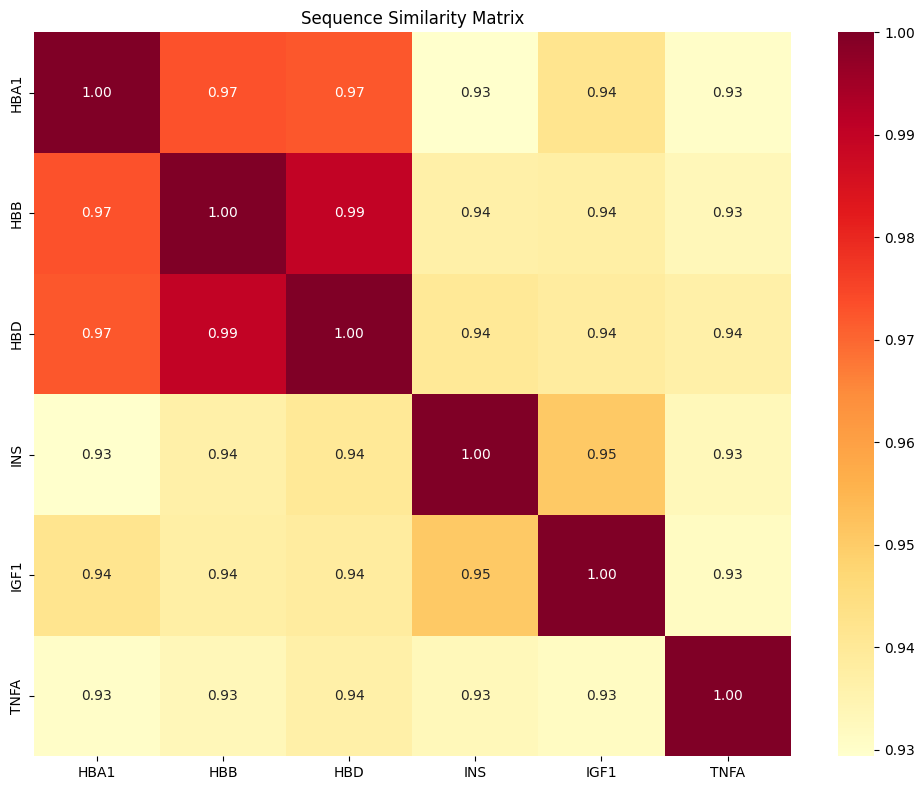


2. Feature Comparison


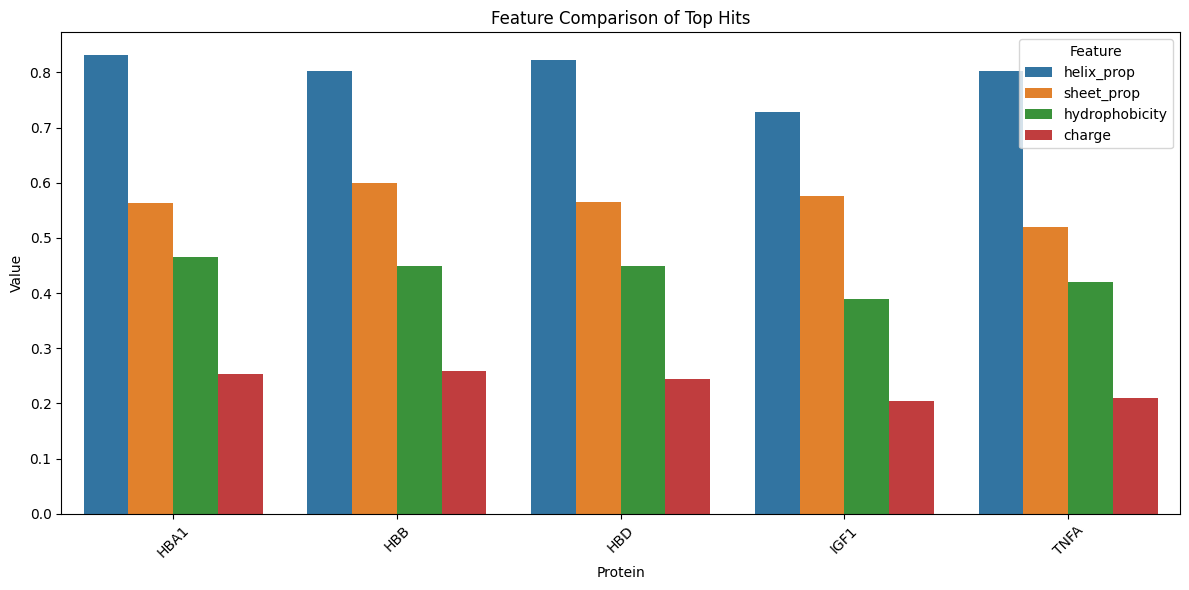


3. Score Distribution


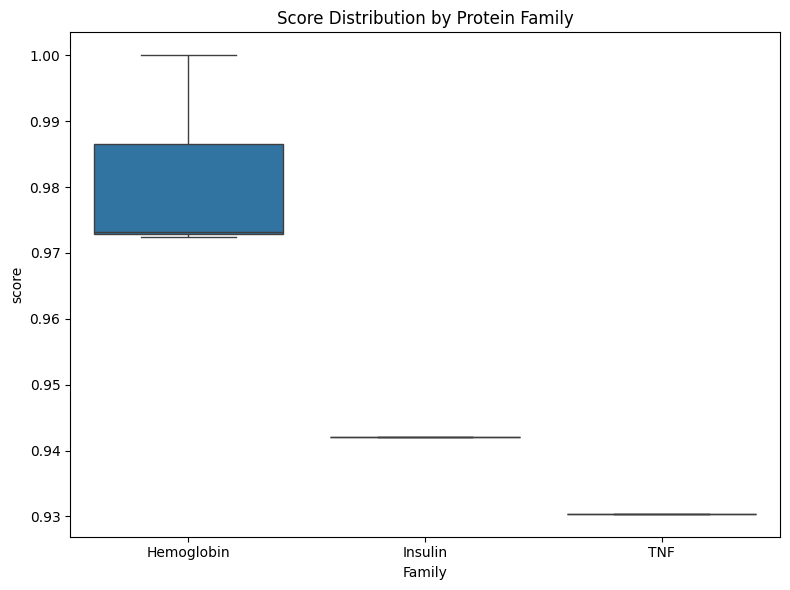


Statistical Analysis:
------------------------------------------------------------

Insulin family:
Average score: 0.942
Score range: 0.942 - 0.942

TNF family:
Average score: 0.930
Score range: 0.930 - 0.930

Hemoglobin family:
Average score: 0.982
Score range: 0.972 - 1.000


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class ResultsVisualizer:
    def __init__(self, results, test_data):
        self.results = results
        self.test_data = test_data

    def plot_similarity_matrix(self):
        """Plot similarity matrix between sequences"""
        proteins = list(self.test_data.keys())
        n = len(proteins)
        matrix = np.zeros((n, n))

        # Compute all-vs-all similarities
        for i, prot1 in enumerate(proteins):
            for j, prot2 in enumerate(proteins):
                query_seq = self.test_data[prot1]['sequence']
                results = blast.search(query_seq, {prot2: self.test_data[prot2]})
                matrix[i,j] = results[0]['score']

        # Plot
        plt.figure(figsize=(10, 8))
        sns.heatmap(matrix,
                   xticklabels=proteins,
                   yticklabels=proteins,
                   cmap='YlOrRd',
                   annot=True,
                   fmt='.2f')
        plt.title('Sequence Similarity Matrix')
        plt.tight_layout()
        plt.show()

    def plot_feature_comparison(self):
        """Plot feature comparison for top hits"""
        features = ['helix_prop', 'sheet_prop', 'hydrophobicity', 'charge']
        proteins = [r['id'] for r in self.results]

        data = []
        for feature in features:
            for hit in self.results:
                data.append({
                    'Protein': hit['id'],
                    'Feature': feature,
                    'Value': hit['features'][feature],
                    'Family': self.test_data[hit['id']]['family']
                })

        df = pd.DataFrame(data)

        plt.figure(figsize=(12, 6))
        sns.barplot(data=df, x='Protein', y='Value', hue='Feature')
        plt.title('Feature Comparison of Top Hits')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_score_distribution(self):
        """Plot score distribution by family"""
        df = pd.DataFrame(self.results)
        df['Family'] = df['id'].map(lambda x: self.test_data[x]['family'])

        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df, x='Family', y='score')
        plt.title('Score Distribution by Protein Family')
        plt.tight_layout()
        plt.show()

def analyze_results(blast, test_data, query_seq):
    """Run comprehensive analysis"""
    # Run search
    results = blast.search(query_seq, test_data)

    # Create visualizer
    viz = ResultsVisualizer(results, test_data)

    print("\nGenerating visualizations...")
    print("\n1. Similarity Matrix")
    viz.plot_similarity_matrix()

    print("\n2. Feature Comparison")
    viz.plot_feature_comparison()

    print("\n3. Score Distribution")
    viz.plot_score_distribution()

    # Statistical analysis
    families = set(data['family'] for data in test_data.values())
    print("\nStatistical Analysis:")
    print("-" * 60)
    for family in families:
        family_scores = [r['score'] for r in results
                        if test_data[r['id']]['family'] == family]
        print(f"\n{family} family:")
        print(f"Average score: {np.mean(family_scores):.3f}")
        print(f"Score range: {np.min(family_scores):.3f} - {np.max(family_scores):.3f}")

    return results

# Usage example
if __name__ == "__main__":
    blast = ImprovedBLAST()
    test_data = PerformanceTester(blast).generate_test_data()
    query_seq = test_data['HBA1']['sequence']

    print("Running analysis...")
    results = analyze_results(blast, test_data, query_seq)